In [1]:
import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice
from superfv.initial_conditions import shu_osher

In [2]:
T = 0.178
N = 400

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "MM3, rtol=1e-1": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-1,
        NAD_atol=0,
        absolute_dmp=True,
        SED=True,
    ),
    "MM3, rtol=1e-5": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-5,
        NAD_atol=0,
        absolute_dmp=True,
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    print(f"Running {name}...")
    sim = EulerSolver(
        ic=shu_osher,
        bcx="free",
        nx=1000 if config.get("MUSCL", False) else N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T)
        elif "RK4" in name:
            sim.rk4(T)
        else:
            sim.run(T)
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Running MUSCL-Hancock...
Step #1068 @ t=1.78e-01 | dt=7.23e-05 | min(rho)=8.00e-01, min(P)=1.00e+00 | (done)                 
Running MM3, rtol=1e-1...
Step #426 @ t=1.78e-01 | dt=5.19e-05 | min(rho)=8.00e-01, min(P)=9.98e-01 | (done)                  
Running MM3, rtol=1e-5...
Step #420 @ t=1.78e-01 | dt=6.78e-05 | min(rho)=8.00e-01, min(P)=9.97e-01 | (done)                  


(0.57, 0.77)

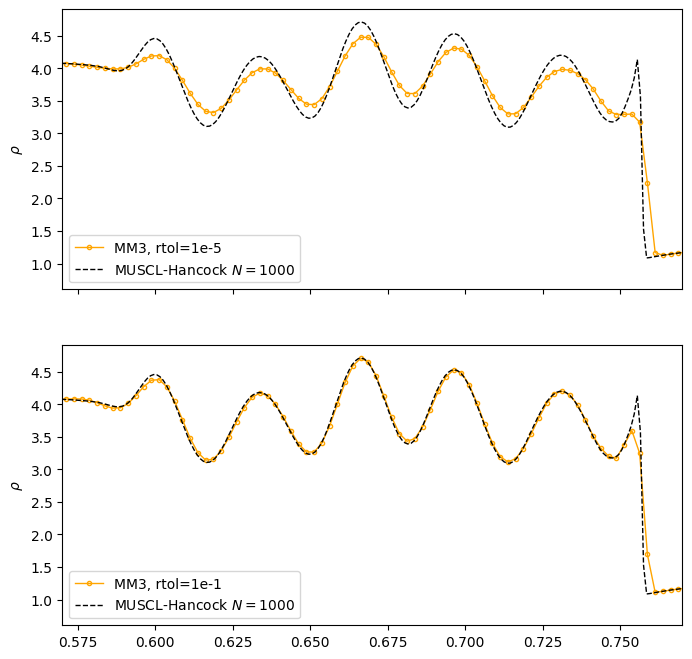

In [3]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey="row", figsize=(8, 8))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$\rho$")


style = dict(linewidth=1, markersize=3)

for name, sim in sims.items():
    if name == "MUSCL-Hancock":
        continue
    j = 0 if sim.MOOD_state.config.NAD_rtol == 1e-5 else 1
    plot_1d_slice(
        sim,
        axs[j],
        "rho",
        label=name,
        marker="o",
        mfc="none",
        color={2: "magenta", 3: "orange", 4: "cyan"}[sim.p],
        **style,
    )

simMH = sims["MUSCL-Hancock"]
plot_1d_slice(
    simMH,
    axs[0],
    "rho",
    label=r"MUSCL-Hancock $N=1000$",
    color="k",
    linestyle="--",
    **style,
)
plot_1d_slice(
    simMH,
    axs[1],
    "rho",
    label=r"MUSCL-Hancock $N=1000$",
    color="k",
    linestyle="--",
    **style,
)

axs[0].legend()
axs[1].legend()

axs[0].set_xlim(0.57, 0.77)